In [3]:
%%capture

!pip install ultralytics
!pip install shapely
!pip install inference_sdk
!pip install inference

In [4]:
from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt


import pandas as pd
import numpy as np
from numpy import asarray
from PIL import Image
from PIL import ImageDraw

import cv2

from shapely.geometry import Polygon
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from inference_sdk import InferenceHTTPClient
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from inference import get_model
from torchvision.models import resnet50, ResNet50_Weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import os

corner_model = get_model(model_id="chessnet-ums8v/3", api_key = "MDFOWssDySBggGwROlEl")
horse_model = get_model(model_id = "chesshorse/1", api_key = "MDFOWssDySBggGwROlEl")

In [5]:
class PieceClassifier(nn.Module):
    def __init__(self):
        super(PieceClassifier, self).__init__()
        self.piece_classifier = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # Replace the final fully connected layer
        self.piece_classifier.fc = nn.Linear(self.piece_classifier.fc.in_features, 8) #[P, H, B, R, Q, K, Blank, Color (0/W - 1/B)]

    def forward(self, x):
        x = self.piece_classifier(x)
        softmax_output = F.softmax(x[:, :7], dim=1)  # Apply softmax to the first 7 outputs
        relu_output = F.relu(x[:, 7])  # Apply ReLU to the 8th output
        final_output = torch.cat((softmax_output, relu_output.unsqueeze(1)), dim=1)  # Concatenate softmax and ReLU outputs
        return final_output

    def calculate_loss(self, output, target):
            softmax_output = output[:, :7]  # First 7 outputs
            relu_output = output[:, 7]  # 8th output

            # Calculate Negative Log Likelihood (NLL) loss for softmax outputs
            nll_loss = F.nll_loss(F.log_softmax(softmax_output, dim=1), target[:, 7].to(torch.long))

            # Calculate Mean Squared Error (MSE) loss for ReLU output
            is_not_blank = (target[:, 6] != 1)
            mse_loss = F.mse_loss(relu_output, target[:, 7]) * is_not_blank #ignore the loss value here for blank space
            # Total loss
            total_loss = nll_loss + mse_loss
            return total_loss

In [6]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")
    median = np.median(pts, axis=0)
    top = np.zeros((2,2), dtype = "float32")
    bottom = np.zeros((2,2), dtype = "float32")
    i1, i2 = 0,0
    pts = pts[np.argsort(-pts[:, 1], axis=0)]
    for row in pts:
        if (row[1] < median[1] or i2 == 2) and i1 < 2: # upper half
            top[i1] = row
            i1 += 1
        else: #lower half
            bottom[i2] = row
            i2 += 1

    #print(top, bottom)
    if top[0][0] < top[1][0]: #0 is upper left
        rect[0] = top[0]
        rect[1] = top[1]
    else:
        rect[0] = top[1]
        rect[1] = top[0]
    if bottom[0][0] < bottom[1][0]: #0 is bottom left
        rect[3] = bottom[0]
        rect[2] = bottom[1]
    else:
        rect[3] = bottom[1]
        rect[2] = bottom[0]
        

    # s = pts.sum(axis = 0)
    # rect[0] = pts[np.argmin(s)]
    # rect[2] = pts[np.argmax(s)]
    
    # diff = np.diff(pts, axis = 1)
    # rect[1] = pts[np.argmin(diff)]
    # rect[3] = pts[np.argmax(diff)]
    #print(rect)
    return rect

In [7]:
def detect_corners(image):
    """
    Detects the corners of a given image. Set show_image to True to display the image with corners and intersections marked.
    """
    results = corner_model.infer( image=Image.open(image), confidence=0.2, iou_threshold=0.2)[0].predictions
    corners = np.array([(box.x, box.y) for box in results])
    return corners

In [8]:
# perspective transforms an image with four given corners

def four_point_transform(image_file, pts):

    img = Image.open(image_file)
    #image = asarray(img)

    rotated_img = img
    image = asarray(rotated_img)

    rect = pts
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))


    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    warped_image = Image.fromarray(warped)
  #  plt.imshow(warped_image)
    horse_loc = horse_model.infer(image=warped_image, confidence=0.1, iou_threshold=0.1)[0].predictions[0]
    if horse_loc.x <= warped_image.width/2 and horse_loc.y <= warped_image.height/2: #in upper left
        return four_point_transform(image_file, np.vstack([pts[1], pts[2], pts[3], pts[0]]))
    elif horse_loc.x > warped_image.width/2 and horse_loc.y <= warped_image.height/2: #in upper right
        return four_point_transform(image_file, np.vstack([pts[2], pts[3], pts[0], pts[1]]))
    elif horse_loc.x > warped_image.width/2 and horse_loc.y > warped_image.height/2: #in bottom right
        return four_point_transform(image_file, np.vstack([pts[3], pts[0], pts[1], pts[2]]))
    
    offx,offy = 0,0
    offx = horse_loc.width * 1.3
    offy = horse_loc.height 
    return warped_image.crop((offx, offy/3, warped_image.size[0] - offx, warped_image.size[1] - offy/3))
    #img = Image.fromarray(warped, "RGB") #to make it black and white as original
    # img.show()
    # return the warped image

In [9]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate( TL, BL )
    ptsR = interpolate( TR, BR )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

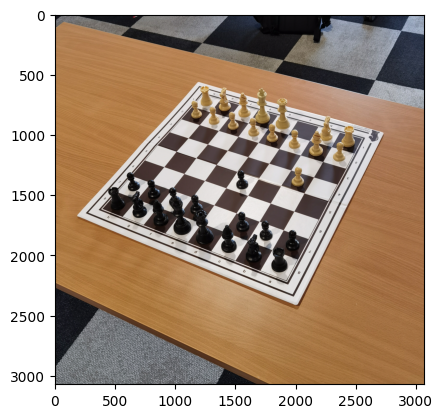

In [10]:
img_str = "app_v2/chessred/images/0/G000_IMG003.jpg"
img_display = Image.open(img_str)
plt.imshow(img_display)

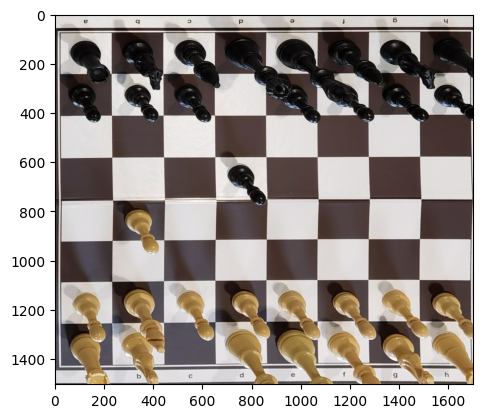

In [11]:
corners = detect_corners(img_str)
transformed_image = four_point_transform(img_str, order_points(corners))
plt.imshow(transformed_image)

In [18]:
#GOING THROUGH FOLDERS = CREATE DATA LOADER
data_path = "app_v2/chessred/images/"
transformed_path = "app_v2/chessred/projected_imgs"
for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            print("Transforming image:", image_path)
            points = detect_corners(image_path)
            if len(points) != 4:
                print("Unable to transform. Moving on...")
                continue
            transformed_image = four_point_transform(image_path, order_points(points)).resize((1024,1024))
            
            output_path = os.path.join(transformed_path, folder_name)
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            transformed_image.save(os.path.join(output_path, filename))
            print(f"Processed image saved: {output_path}")


Transforming image: app_v2/chessred/images/61/G061_IMG012.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG006.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG007.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG013.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG005.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG011.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG039.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G061_IMG038.jpg
Processed image saved: app_v2/chessred/projected_imgs/61
Transforming image: app_v2/chessred/images/61/G0

In [ ]:
folder_path = "output"
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(folder_path, filename)
        print(Image.open(image_path).size)


(2168, 1778)
(2294, 1627)
(1600, 1494)
(2140, 1362)
(1405, 2122)
(1673, 1974)
(1527, 2088)
(1467, 1896)
(1067, 2439)
(1953, 1620)
(1811, 1552)
(1283, 2049)
(1823, 2274)
(2426, 1737)
(1575, 2361)
(804, 2163)
(1761, 1874)
(1678, 1609)
(1763, 1820)
(2129, 1831)
(1730, 1443)
(1358, 2101)
(1669, 1971)
(2109, 1383)
(1767, 2823)
(1477, 2406)
(1932, 1664)
(1541, 964)
(1857, 1973)
(1830, 1464)
(1709, 1550)
(2165, 1863)
(1727, 1695)
(1941, 1850)
(1230, 1892)
(2221, 1907)
(2177, 1445)
(1512, 2634)
(2359, 1652)
(2251, 1711)
(1372, 2527)
(1783, 2468)
(1848, 1732)
(1389, 2005)
(2100, 1304)
(2153, 1826)
(1238, 1824)
(2062, 1387)
(2222, 1646)
(2516, 1930)
(1826, 2100)
(1822, 2066)
(1473, 2464)
(2158, 1570)
(1700, 1553)
(1207, 1930)
(1686, 1544)
(1931, 1935)
(1729, 2138)
(1853, 1524)
(987, 2264)
(1669, 1976)
(1902, 1353)
(1253, 1644)
(1173, 2369)
(1499, 1829)
(1687, 2052)
(2074, 1681)
(2019, 2134)
(1802, 2077)
(1956, 1542)
(1877, 1696)
(1369, 2362)
(2419, 1242)
(2022, 1630)
(2060, 1615)
(1615, 1168)
(1

## Complete

In [ ]:
import numpy as np

image = 'BoardPics/board9.JPG'

#latent_size = (350,350)

corners = detect_corners(image)

transformed_image = four_point_transform(image, corners)

plt.imshow(transformed_image)
plt.show()

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image)

detections, boxes = chess_pieces_detector(transformed_image)

#calculate the grid

xA = ptsT[0][0]
xB = ptsT[1][0]
xC = ptsT[2][0]
xD = ptsT[3][0]
xE = ptsT[4][0]
xF = ptsT[5][0]
xG = ptsT[6][0]
xH = ptsT[7][0]
xI = ptsT[8][0]

y9 = ptsL[0][1]
y8 = ptsL[1][1] 
y7 = ptsL[2][1] 
y6 = ptsL[3][1]  
y5 = ptsL[4][1]  
y4 = ptsL[5][1] 
y3 = ptsL[6][1]  
y2 = ptsL[7][1] 
y1 = ptsL[8][1] 

#calculate all the squares

a8 = np.array([[xA,y9], [xB, y9], [xB, y8], [xA, y8]])
a7 = np.array([[xA,y8], [xB, y8], [xB, y7], [xA, y7]])
a6 = np.array([[xA,y7], [xB, y7], [xB, y6], [xA, y6]])
a5 = np.array([[xA,y6], [xB, y6], [xB, y5], [xA, y5]])
a4 = np.array([[xA,y5], [xB, y5], [xB, y4], [xA, y4]])
a3 = np.array([[xA,y4], [xB, y4], [xB, y3], [xA, y3]])
a2 = np.array([[xA,y3], [xB, y3], [xB, y2], [xA, y2]])
a1 = np.array([[xA,y2], [xB, y2], [xB, y1], [xA, y1]])

b8 = np.array([[xB,y9], [xC, y9], [xC, y8], [xB, y8]])
b7 = np.array([[xB,y8], [xC, y8], [xC, y7], [xB, y7]])
b6 = np.array([[xB,y7], [xC, y7], [xC, y6], [xB, y6]])
b5 = np.array([[xB,y6], [xC, y6], [xC, y5], [xB, y5]])
b4 = np.array([[xB,y5], [xC, y5], [xC, y4], [xB, y4]])
b3 = np.array([[xB,y4], [xC, y4], [xC, y3], [xB, y3]])
b2 = np.array([[xB,y3], [xC, y3], [xC, y2], [xB, y2]])
b1 = np.array([[xB,y2], [xC, y2], [xC, y1], [xB, y1]])

c8 = np.array([[xC,y9], [xD, y9], [xD, y8], [xC, y8]])
c7 = np.array([[xC,y8], [xD, y8], [xD, y7], [xC, y7]])
c6 = np.array([[xC,y7], [xD, y7], [xD, y6], [xC, y6]])
c5 = np.array([[xC,y6], [xD, y6], [xD, y5], [xC, y5]])
c4 = np.array([[xC,y5], [xD, y5], [xD, y4], [xC, y4]])
c3 = np.array([[xC,y4], [xD, y4], [xD, y3], [xC, y3]])
c2 = np.array([[xC,y3], [xD, y3], [xD, y2], [xC, y2]])
c1 = np.array([[xC,y2], [xD, y2], [xD, y1], [xC, y1]])

d8 = np.array([[xD,y9], [xE, y9], [xE, y8], [xD, y8]])
d7 = np.array([[xD,y8], [xE, y8], [xE, y7], [xD, y7]])
d6 = np.array([[xD,y7], [xE, y7], [xE, y6], [xD, y6]])
d5 = np.array([[xD,y6], [xE, y6], [xE, y5], [xD, y5]])
d4 = np.array([[xD,y5], [xE, y5], [xE, y4], [xD, y4]])
d3 = np.array([[xD,y4], [xE, y4], [xE, y3], [xD, y3]])
d2 = np.array([[xD,y3], [xE, y3], [xE, y2], [xD, y2]])
d1 = np.array([[xD,y2], [xE, y2], [xE, y1], [xD, y1]])

e8 = np.array([[xE,y9], [xF, y9], [xF, y8], [xE, y8]])
e7 = np.array([[xE,y8], [xF, y8], [xF, y7], [xE, y7]])
e6 = np.array([[xE,y7], [xF, y7], [xF, y6], [xE, y6]])
e5 = np.array([[xE,y6], [xF, y6], [xF, y5], [xE, y5]])
e4 = np.array([[xE,y5], [xF, y5], [xF, y4], [xE, y4]])
e3 = np.array([[xE,y4], [xF, y4], [xF, y3], [xE, y3]])
e2 = np.array([[xE,y3], [xF, y3], [xF, y2], [xE, y2]])
e1 = np.array([[xE,y2], [xF, y2], [xF, y1], [xE, y1]])

f8 = np.array([[xF,y9], [xG, y9], [xG, y8], [xF, y8]])
f7 = np.array([[xF,y8], [xG, y8], [xG, y7], [xF, y7]])
f6 = np.array([[xF,y7], [xG, y7], [xG, y6], [xF, y6]])
f5 = np.array([[xF,y6], [xG, y6], [xG, y5], [xF, y5]])
f4 = np.array([[xF,y5], [xG, y5], [xG, y4], [xF, y4]])
f3 = np.array([[xF,y4], [xG, y4], [xG, y3], [xF, y3]])
f2 = np.array([[xF,y3], [xG, y3], [xG, y2], [xF, y2]])
f1 = np.array([[xF,y2], [xG, y2], [xG, y1], [xF, y1]])

g8 = np.array([[xG,y9], [xH, y9], [xH, y8], [xG, y8]])
g7 = np.array([[xG,y8], [xH, y8], [xH, y7], [xG, y7]])
g6 = np.array([[xG,y7], [xH, y7], [xH, y6], [xG, y6]])
g5 = np.array([[xG,y6], [xH, y6], [xH, y5], [xG, y5]])
g4 = np.array([[xG,y5], [xH, y5], [xH, y4], [xG, y4]])
g3 = np.array([[xG,y4], [xH, y4], [xH, y3], [xG, y3]])
g2 = np.array([[xG,y3], [xH, y3], [xH, y2], [xG, y2]])
g1 = np.array([[xG,y2], [xH, y2], [xH, y1], [xG, y1]])

h8 = np.array([[xH,y9], [xI, y9], [xI, y8], [xH, y8]])
h7 = np.array([[xH,y8], [xI, y8], [xI, y7], [xH, y7]])
h6 = np.array([[xH,y7], [xI, y7], [xI, y6], [xH, y6]])
h5 = np.array([[xH,y6], [xI, y6], [xI, y5], [xH, y5]])
h4 = np.array([[xH,y5], [xI, y5], [xI, y4], [xH, y4]])
h3 = np.array([[xH,y4], [xI, y4], [xI, y3], [xH, y3]])
h2 = np.array([[xH,y3], [xI, y3], [xI, y2], [xH, y2]])
h1 = np.array([[xH,y2], [xI, y2], [xI, y1], [xH, y1]])

# transforms the squares to write FEN

FEN_annotation = [[a8, b8, c8, d8, e8, f8, g8, h8],
                [a7, b7, c7, d7, e7, f7, g7, h7],
                [a6, b6, c6, d6, e6, f6, g6, h6],
                [a5, b5, c5, d5, e5, f5, g5, h5],
                [a4, b4, c4, d4, e4, f4, g4, h4],
                [a3, b3, c3, d3, e3, f3, g3, h3],
                [a2, b2, c2, d2, e2, f2, g2, h2],
                [a1, b1, c1, d1, e1, f1, g1, h1]]

board_FEN = []
corrected_FEN = []
complete_board_FEN = []

for line in FEN_annotation:
    line_to_FEN = []
    for square in line:
        piece_on_square = connect_square_to_detection(detections, square)    
        line_to_FEN.append(piece_on_square)
    corrected_FEN = [i.replace('empty', '1') for i in line_to_FEN]
    print(corrected_FEN)
    board_FEN.append(corrected_FEN)

complete_board_FEN = [''.join(line) for line in board_FEN] 

to_FEN = '/'.join(complete_board_FEN)

print("https://lichess.org/analysis/"+to_FEN)

ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

def fen_to_board(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == ' ':
                break
            elif c in '12345678':
                brow.extend( [" "] * int(c) )
            else:
                brow.append(c)

        board.append( brow )
   # print(board)
    return [[element for element in row] for row in board]

from pprint import pprint
pprint( fen_to_board(fen) )

#train_data = [
#    (
#        transforms.ToTensor()(training_data_temp[0][0]).unsqueeze(0),  # Input tensor
#        torch.tensor([[1, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.float32)  # Target tensor
#    )
#]

def avi_to_vec(inp): #avi character to vector; #[P, N, B, R, Q, K, ' ', Color (0/W - 1/B)] ["lowercase is white"]
    v = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
    v[0][-1] = (0 if inp.islower() else 1)
    map = {"p": 0, "n": 1, "b": 2, "r": 3, "q":4, "k":5,  " ": 6}
    if inp in map: v[0][map[inp]] = 1
    elif inp.lower() in map: v[0][map[inp.lower()]] = 1
    return v

def vec_to_avi(v):
    c = ' '
    map = {0:"p", 1:"n", 2:"b", 3:"r", 4:"q", 5:"k",  6:" "}
    for i in range(7):
        if v[0][i] == 1:
            c = map[i]
            break
    if v[0][-1] == 1: c = c.upper()
    return c
    

[['r', 'n', 'b', 'q', 'k', 'b', 'n', 'r'],
 ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
 ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']]


In [ ]:
def crop_board(projected_image):
  images = []
  w, h = projected_image.size[0]/8, projected_image.size[1]/8, 
  for i in range(8):
    for j in range(8):
      sub = projected_image.crop((j * w, i * h, (j+1) * w, (i+1) * h))
      sub = sub.resize((int(w), int(h)))
      images.append(sub)
  return images

def create_data_pairs(image_filename, fen_notation):
  corners = detect_corners(image_filename)
  projected_image = four_point_transform(image_filename, corners)
  labels = [avi_to_vec(element) for element in np.array(fen_to_board(fen_notation)).flatten()] #changing data to vector format
  images = [transforms.ToTensor()(img).unsqueeze(0) for img in crop_board(projected_image)] #changing images to proper tensors; remove for nice pics
  return list(zip(images, labels))


64


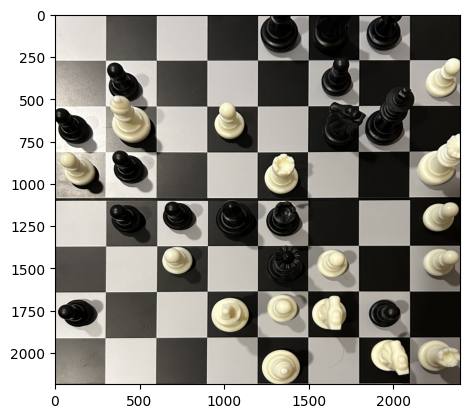

In [ ]:
m =create_data_pairs(transformed_image, "4bnr1/1p3p1P/pB1P1nk1/Pp2R2Q/1ppbr2P/2P1qP1P/p2KPNp1/4B1NR w KQkq - 0 1")
print(len(m))
#print(m)
plt.imshow(transformed_image)


tensor([[1., 0., 0., 0., 0., 0., 0., 0.]])


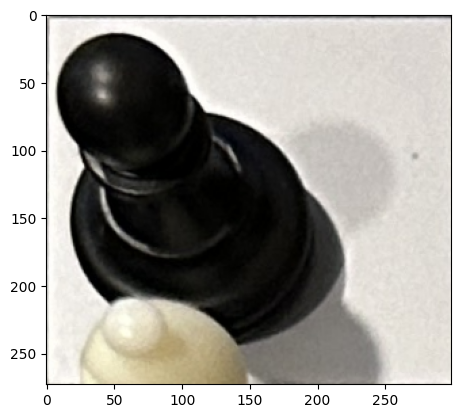

In [ ]:
#To Display Individual Pieces
loc = (1, 1) #row, col
plt.imshow(m[loc[0] * 8 + loc[1]][0][0].numpy().transpose(1, 2, 0))
print(m[loc[0] * 8 + loc[1]][1])

In [ ]:
def board_to_fen(board):
    """
    Convert a board into FEN notation.

    Args:
        board: 2d array of cells, each of which is a string representing the piece at that location
    
    Returns:
        A string in FEN notation corresponding to the board, with arbitrary values for everything except piece placement data (since we do not have that information).
    """
    fen = ""
    for row in board:
        copy = [x for x in row]
        while len(copy) > 0:
            char = copy.pop(0)
            assert len(char) == 1 and isinstance(char, str)
            if char == " ":
                count = 1
                while copy and copy[0] == " ":
                    copy.pop(0)
                    count += 1
                fen += str(count)
            else:
                fen += char
        fen += "/"
            
    return fen[:-1] + " w KQkq - 0 1"


In [ ]:
from stockfish import Stockfish

stockfish = Stockfish("./stockfish")

squares = [letter+number for letter in "abcdefgh" for number in "12345678"]
valid_moves = [square1+square2 for square1 in squares for square2 in squares]


def move_to_reach(start_fen, end_fen) -> str | None:
    """Returns the move which takes start_fen to end_fen, or None if no such move exists."""
    for move in valid_moves:
        stockfish.set_fen_position(start_fen)
        if stockfish.is_move_correct(move):
            stockfish.make_moves_from_current_position([move])
            # only compare piece placement data (the first component of FEN notation)
            if stockfish.get_fen_position().split(" ")[0] == end_fen.split(" ")[0]: 
                return move
    return None

In [ ]:
random_positions = [
    "4bnr1/1p3p1P/pB1P1nk1/Pp2R2Q/1ppbr2P/2P1qP1P/p2KPNp1/4B1NR w KQkq - 0 1",
    "2rB4/q2kRpP1/b6P/ppPP1P2/pp1N1Pn1/rQ1p2pN/nP1BPp2/1K2Rb2 w KQkq - 0 1",
    "2BRb3/Qr1P1p1P/PpP4p/1b1PPn2/BPN1q1p1/p2p1Rpp/P2n1Nk1/1r1K4 w KQkq - 0 1",
    "5R2/2ppN3/3Pp1bp/Q1PPKPp1/np1r3B/p1P1pPPr/P2B2kq/1N2Rn1b w KQkq - 0 1",
    "N3Kb1Q/rP1q1P1P/5Pp1/PP3P1p/nN1r1Pp1/R1pppk1p/p2nRb2/6BB w KQkq - 0 1",
    "Q1N3N1/pP3P1p/2B1B2p/pRPPR1P1/1rKPq1bp/p1p2PP1/2nbp3/2n3kr w KQkq - 0 1",
    "1N4r1/1p1N1Rq1/Bp1pPQkP/BpK4n/PP2ppPP/1r2pn1p/1R2PP2/3b2b1 w KQkq - 0 1",
    "q1n1N3/np4PP/pbPPP1pr/7p/PQ1ppPbk/2p2p1P/1RB1rN1K/RB6 w KQkq - 0 1",
    "3bbr1r/Kpp1pRPP/Np4pR/p2PB1Np/PBP1QP2/P3Pnq1/1pn2k2/8 w KQkq - 0 1",
    "B1r5/K2n2nP/PN2Qp2/p1pRPPkP/2p2b2/pp1PP3/PRpqB1pr/4N1b1 w KQkq - 0 1",
]

In [ ]:
# train_data = [
#     (
#         transforms.ToTensor()(training_data_temp[0][0]).unsqueeze(0),  # Input tensor
#         torch.tensor([[1, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.float32)  # Target tensor
#     )
# ]

#Create Training Data
train_data = []
for filename in os.listdir("BoardPics"):
    if filename.endswith('.JPG'):  # Check if the file is a JPEG image
        # Construct the full file path
        num = int(filename[filename.find('d') + 1: filename.find('.')])
        file_path = os.path.join("BoardPics", filename)
        train_data.extend(create_data_pairs(file_path, random_positions[num]))
        
print(len(train_data))

piece_classifier = PieceClassifier()
optimizer = optim.Adam(piece_classifier.parameters(), lr=0.001)
num_epochs = 3
piece_classifier.train()  # Set the model to training mode
for epoch in range(num_epochs):
   # running_loss = 0.0
    for inputs, labels in train_data:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = piece_classifier(inputs)  # Forward pass
       # print(outputs)
        loss = piece_classifier.calculate_loss(outputs, labels)  # Calculate the loss
        #print(loss)
        loss.backward()  # Backward propogate
        optimizer.step()  # Optimize

    #    running_loss += loss.item() * inputs.size(0)

    #epoch_loss = running_loss / len(train_data)


[[     2725.5        2957]
 [     2569.5         777]
 [      328.5        2941]
 [        479         775]
 [     2603.5        1256]]
[[        479         775]
 [     2569.5         777]
 [     2725.5        2957]
 [      328.5        2941]]
[[       2943        3114]
 [     2693.5         769]
 [        215        3056]
 [        495         756]
 [        336        2080]
 [        239        2552]
 [      402.5      1379.5]]
[[        495         756]
 [     2693.5         769]
 [       2943        3114]
 [        215        3056]]
[[      385.5       737.5]
 [       2594       762.5]
 [        142      3083.5]
 [       2854        2592]
 [     2859.5        3048]
 [       2950      3150.5]
 [      950.5       744.5]]
[[      385.5       737.5]
 [       2594       762.5]
 [       2950      3150.5]
 [        142      3083.5]]
[[     2865.5        3190]
 [       2569         890]
 [      151.5      3231.5]
 [      385.5         871]
 [        336      1133.5]]
[[      385.5        

tensor([[8.9232e-14, 1.0000e+00, 3.5295e-14, 5.1026e-14, 9.2444e-14, 5.6656e-14, 6.9968e-14, 0.0000e+00]])
tensor([[1., 0., 0., 0., 0., 0., 0., 1.]])


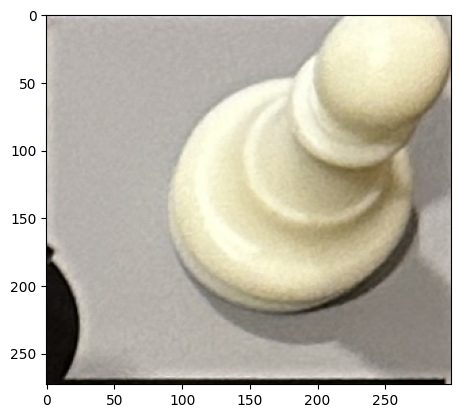

In [ ]:
#To Display Individual Pieces
index = 15
plt.imshow(train_data[index][0][0].numpy().transpose(1, 2, 0))
label = m[index][1]
piece_classifier.eval()
with torch.no_grad():
    output = piece_classifier(train_data[index][0])
print(output)
print(label)

[[      114.5        3362]
 [       2769      3377.5]
 [       2586        1003]
 [      350.5       947.5]
 [     1689.5      1994.5]]
[[      350.5       947.5]
 [       2586        1003]
 [       2769      3377.5]
 [      114.5        3362]]


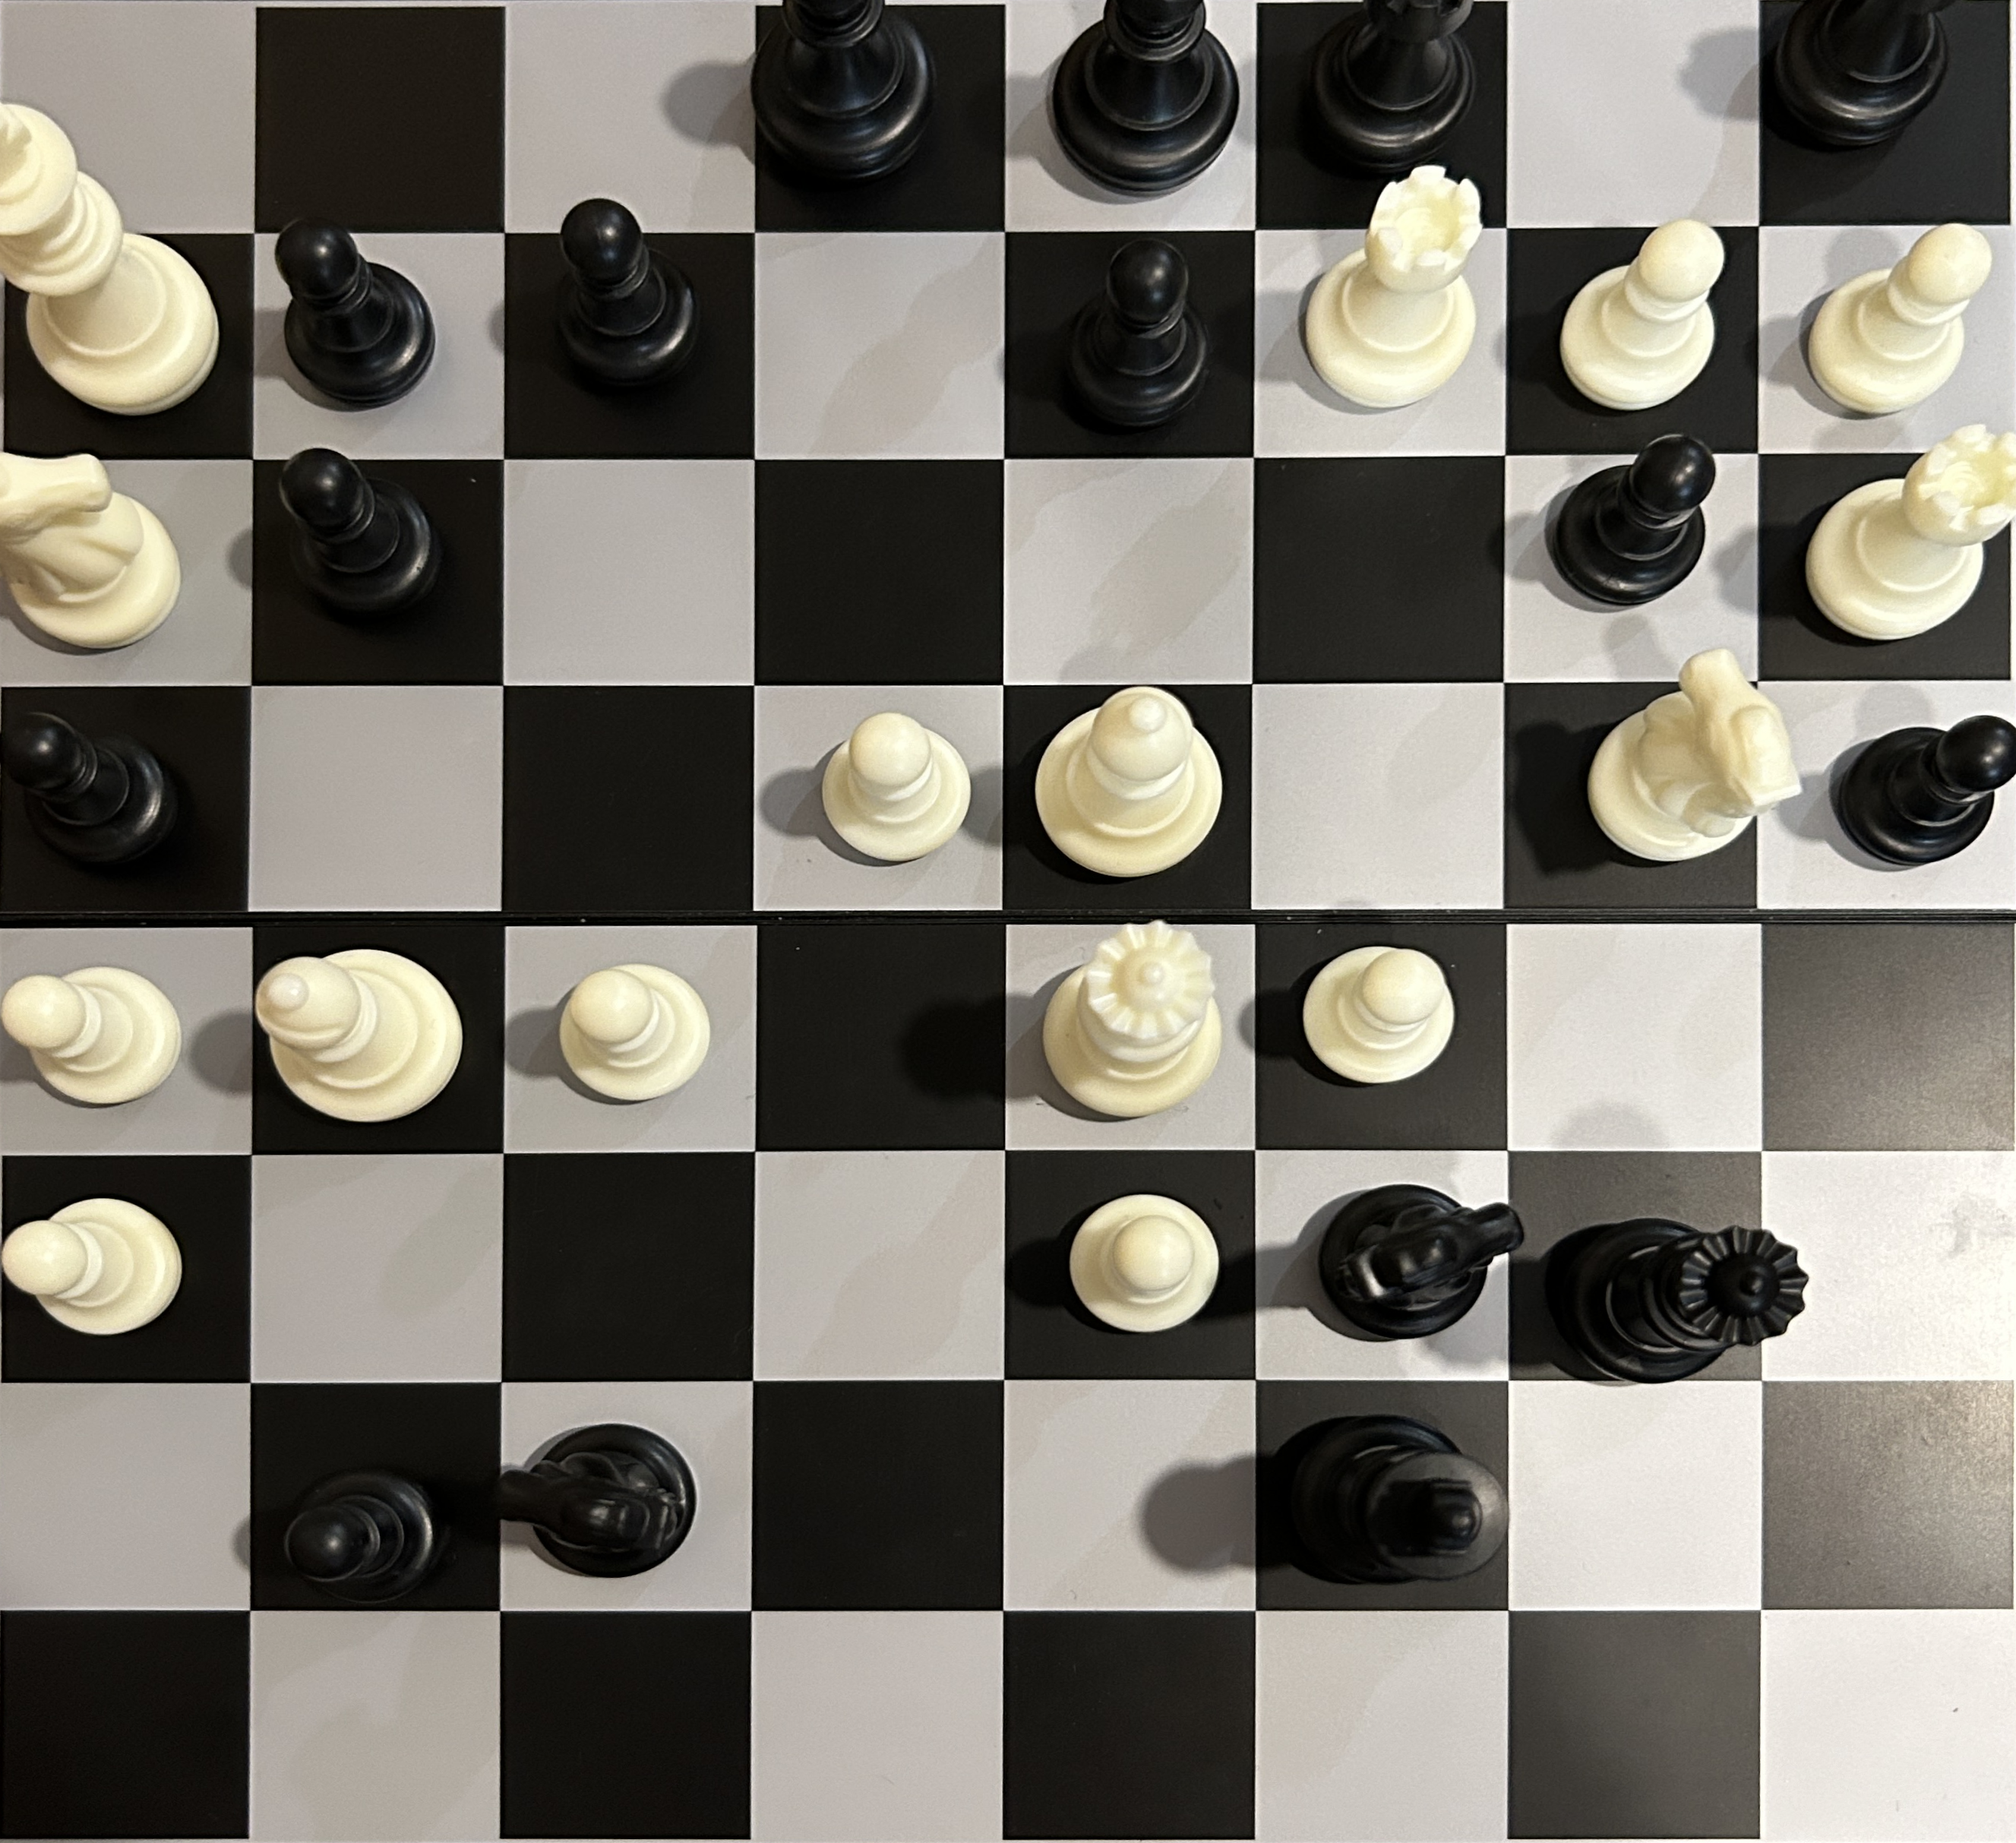

In [ ]:
i = "BoardPics/board8.JPG"
#plt.imshow(Image.open(i).rotate(-90))
four_point_transform(i, detect_corners(i))